In [ ]:
!pip install keras

In [17]:
# import cv2
# import numpy as np

# path_mask_test = '/Users/arahjou/Downloads/Medical_seg/dataset_UWM_GI_Tract_train_valid/valid/masks/case9_day0_slice_0060_360_310_1.50_1.50.png'
# mask_test = cv2.imread(path_mask_test, 0)

# # Assuming train_masks is a NumPy array
# unique_values = np.unique(mask_test)
# print(unique_values)


[  0  95 106 113]


In [2]:
from simple_multi_unet_model import multi_unet_model #Uses softmax 

from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes = 4 #Number of classes for segmentation

In [4]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("/Users/arahjou/Downloads/dataset_UWM_GI_Tract_train_valid/train/images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [5]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("/Users/arahjou/Downloads/dataset_UWM_GI_Tract_train_valid/train/masks/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [5]:
train_masks.shape

(13238, 128, 128)

In [6]:
import numpy as np

# Assuming train_masks is a NumPy array
unique_values = np.unique(train_masks)
print(unique_values)

[0 1 2 3]


In [6]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1)  # Flatten the array to 1D
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

array([0, 1, 2, 3])

In [7]:
#################################################
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [0 1 2 3]


In [8]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_masks_reshaped_encoded),
#                                                  train_masks_reshaped_encoded)
# print("Class weights are...:", class_weights)


from sklearn.utils import compute_class_weight

# Calculating class weights (assuming you have class labels in 'train_masks_reshaped_encoded')
class_weights_array = compute_class_weight(class_weight='balanced',
                                           classes=np.unique(train_masks_reshaped_encoded),
                                           y=train_masks_reshaped_encoded)

# Convert array to dictionary to use with Keras
#class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
#print("Class weights are...:", class_weights)

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=2, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    


model.save('test.hdf5')
#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')

Class weights are...: {0: 0.2603325167522041, 1: 29.731513639479097, 2: 16.763183774139865, 3: 15.274200886037404}
Epoch 1/2
596/596 ━━━━━━━━━━━━━━━━━━━━ 170s 283ms/step - accuracy: 0.9512 - loss: 0.1784 - val_accuracy: 0.9679 - val_loss: 0.0853
Epoch 2/2
596/596 ━━━━━━━━━━━━━━━━━━━━ 167s 280ms/step - accuracy: 0.9717 - loss: 0.0758 - val_accuracy: 0.9799 - val_loss: 0.0532


In [ ]:
#V2

In [17]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_masks_reshaped_encoded),
#                                                  train_masks_reshaped_encoded)
# print("Class weights are...:", class_weights)

import tensorflow as tf

def f1_score(y_true, y_pred):
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    y_pred_binary = tf.round(y_pred)  # Assuming y_pred are probabilities that need to be converted to binary values
    
    precision.update_state(y_true, y_pred_binary)
    recall.update_state(y_true, y_pred_binary)
    
    p = precision.result()
    r = recall.result()
    
    f1 = 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))  # Adding epsilon to avoid division by zero
    return f1


from sklearn.utils import compute_class_weight

# Calculating class weights (assuming you have class labels in 'train_masks_reshaped_encoded')
class_weights_array = compute_class_weight(class_weight='balanced',
                                           classes=np.unique(train_masks_reshaped_encoded),
                                           y=train_masks_reshaped_encoded)

# Convert array to dictionary to use with Keras
class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
print("Class weights are...:", class_weights)

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_score])
#model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=2, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    


model.save('test.hdf5')
#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')

Class weights are...: {0: 0.2603325167522041, 1: 29.731513639479097, 2: 16.763183774139865, 3: 15.274200886037404}
Epoch 1/2


ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.

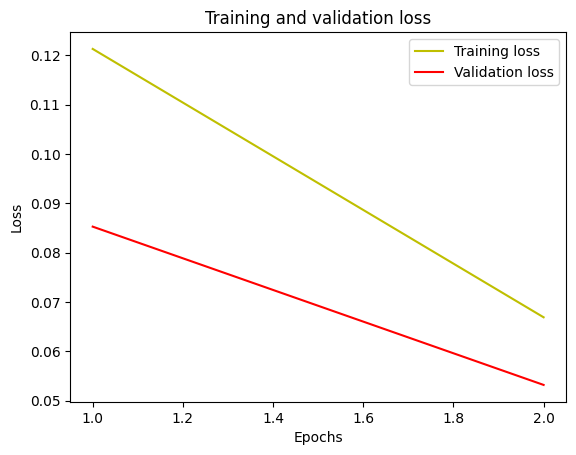

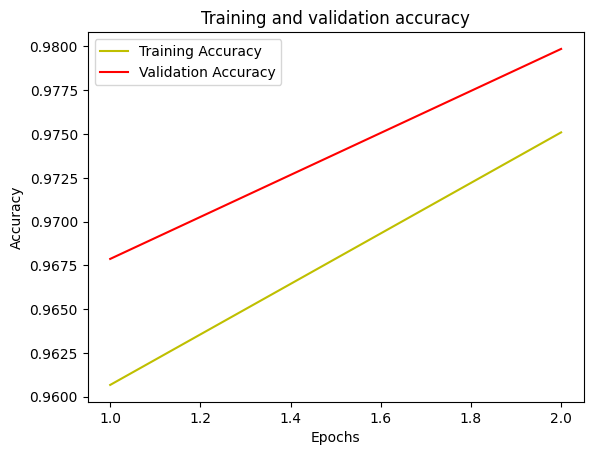

In [9]:
# Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting the loss
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Fetching the correct accuracy keys
acc = history.history['accuracy']  # Updated key for accuracy
val_acc = history.history['val_accuracy']  # Updated key for validation accuracy

# Plotting the accuracy
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [10]:
#model = get_model()
#model.load_weights('sandstone_50_epochs_catXentropy_acc.hdf5')  
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')  

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step


In [13]:
import tensorflow as tf
from keras.metrics import MeanIoU

# Assuming y_test and y_pred_argmax are defined elsewhere and have appropriate shapes
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

# Accessing the confusion matrix using the internal state of the MeanIoU metric
confusion_mtx = IOU_keras.total_cm.numpy()  # Accessing the total_cm property to get the confusion matrix
print(confusion_mtx)

class1_IoU = confusion_mtx[0, 0] / (np.sum(confusion_mtx[0, :]) + np.sum(confusion_mtx[:, 0]) - confusion_mtx[0, 0])
class2_IoU = confusion_mtx[1, 1] / (np.sum(confusion_mtx[1, :]) + np.sum(confusion_mtx[:, 1]) - confusion_mtx[1, 1])
class3_IoU = confusion_mtx[2, 2] / (np.sum(confusion_mtx[2, :]) + np.sum(confusion_mtx[:, 2]) - confusion_mtx[2, 2])
class4_IoU = confusion_mtx[3, 3] / (np.sum(confusion_mtx[3, :]) + np.sum(confusion_mtx[:, 3]) - confusion_mtx[3, 3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)


Mean IoU = 0.6634984
[[1.6777216e+07 3.0765000e+04 1.1086700e+05 6.4763000e+04]
 [3.4697000e+04 1.4359300e+05 3.6120000e+03 3.0870000e+03]
 [6.4289000e+04 4.1800000e+03 2.1261900e+05 3.1686000e+04]
 [4.3373000e+04 8.6470000e+03 3.6902000e+04 2.6906100e+05]]
IoU for class1 is:  0.9796361
IoU for class2 is:  0.6281931
IoU for class3 is:  0.45807758
IoU for class4 is:  0.5880871


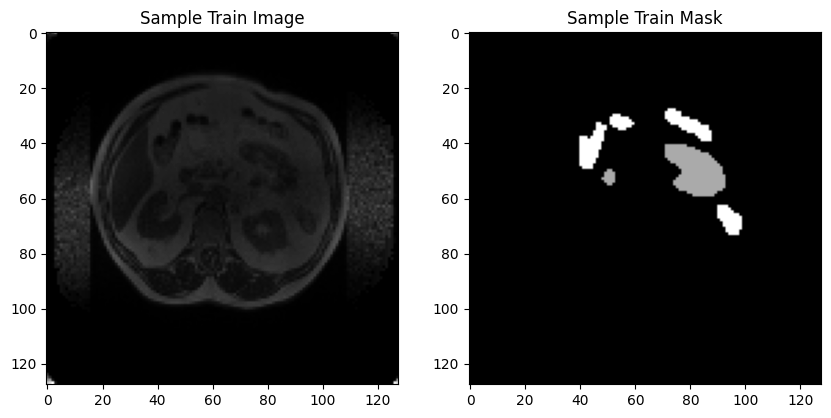

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_images[0, :, :, 0], cmap='gray')
plt.title('Sample Train Image')
plt.subplot(1, 2, 2)
plt.imshow(train_masks[0], cmap='gray')
plt.title('Sample Train Mask')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


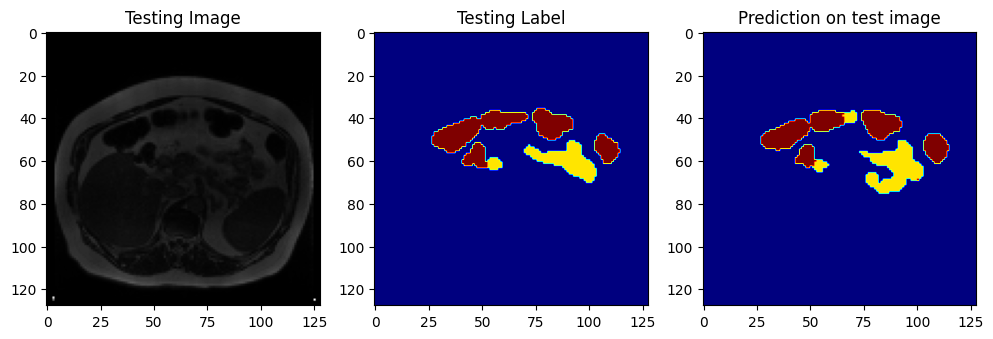

In [15]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [ ]:
#Predict on large image

#Apply a trained model on large image

from patchify import patchify, unpatchify

large_image = cv2.imread('large_images/large_image.tif', 0)
#This will split the image into small images of shape [3,3]
patches = patchify(large_image, (128, 128), step=128)  #Step=256 for 256 patches means no overlap

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print(i,j)
        
        single_patch = patches[i,j,:,:]       
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
        single_patch_input=np.expand_dims(single_patch_norm, 0)
        single_patch_prediction = (model.predict(single_patch_input))
        single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
plt.imshow(reconstructed_image, cmap='gray')
#plt.imsave('data/results/segm.jpg', reconstructed_image, cmap='gray')

plt.hist(reconstructed_image.flatten())  #Threshold everything above 0

# final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# plt.imshow(final_prediction)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap='jet')
plt.show()